## Collaborative Filtering

- finding similar items, given some set of data
- and then find latent factors

In [11]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)
pd.options.display.max_rows = 7

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


- ideally we want to fill in information about each genre the movie is in
- goal is to create latent factors:
    - we don't know what factors are important to people, but lets try using SGD to find them
    
Idea:
For every movie and users, pick a set of random numbers and factors. (matrix multiply of row and column is the dotproduct)
- we predict their rating of the movie, and optimise based on RMSE

Embedding:
- Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix. 
- these embeddings capture some feature of the data on the relationships between users and movies

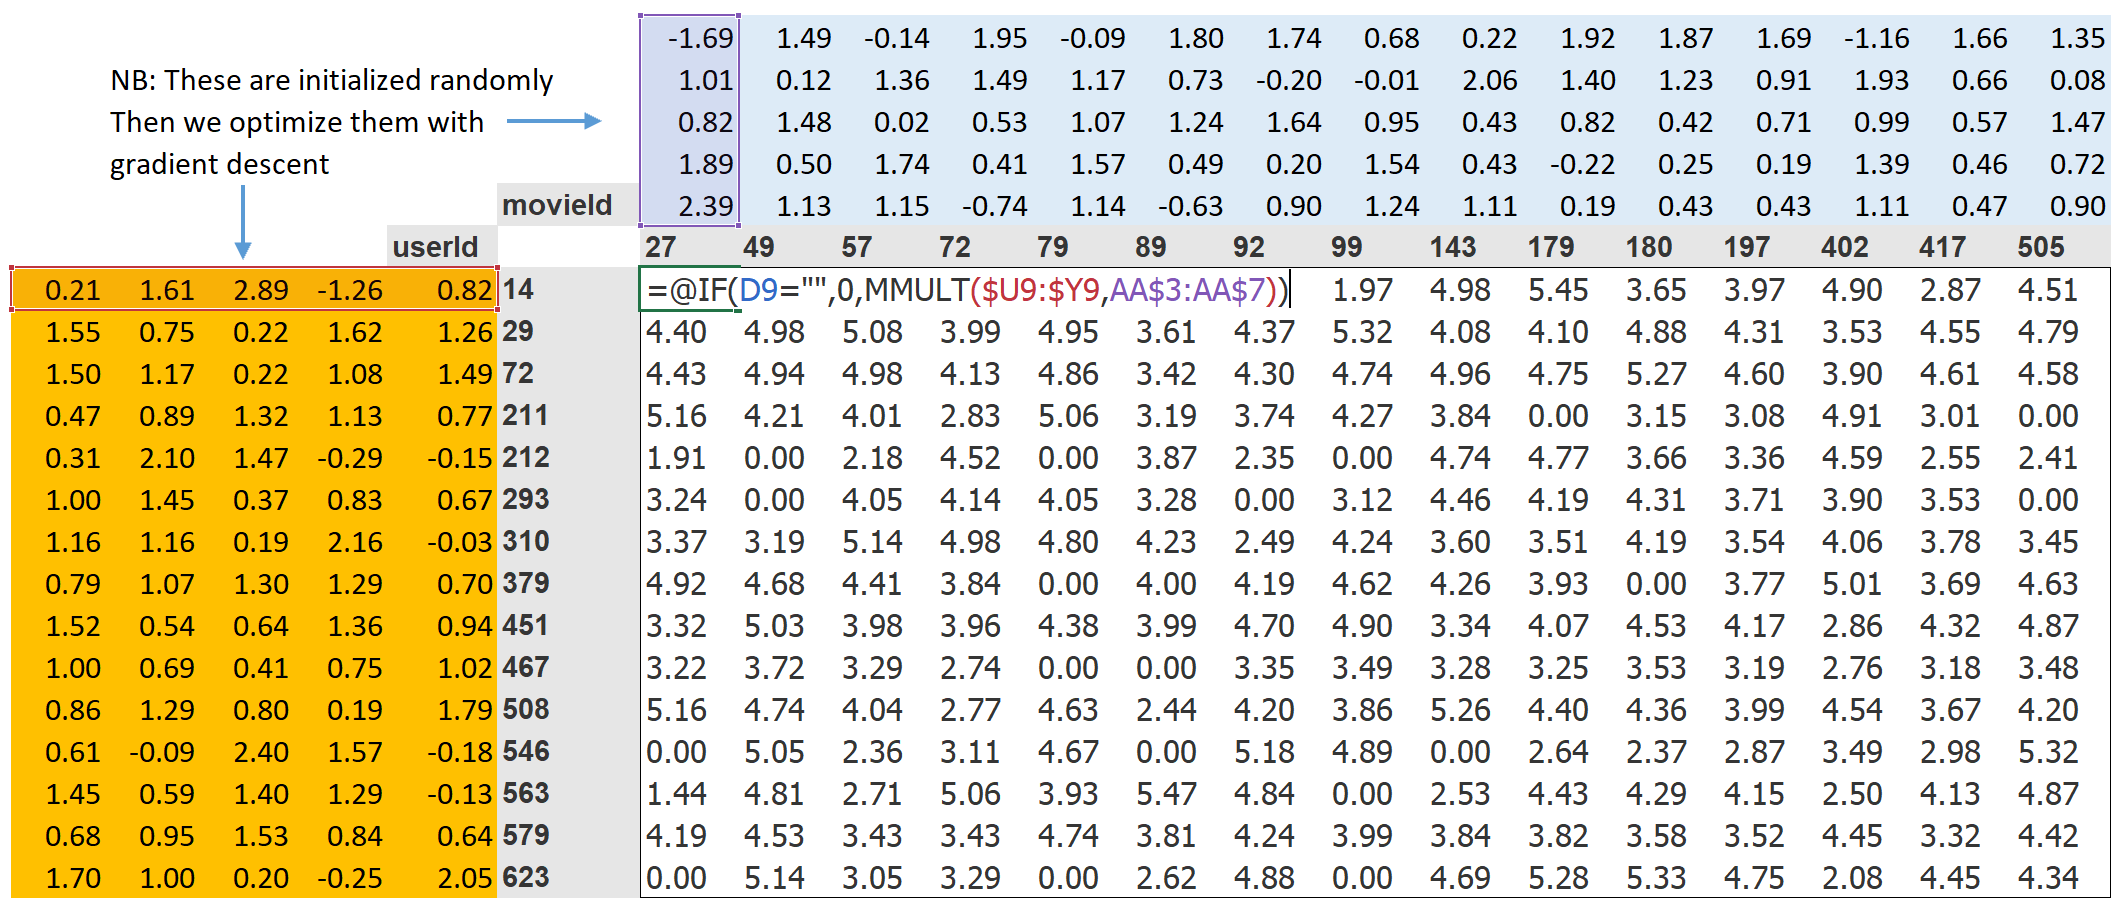

## Creating the Data Loaders

In [5]:
# matching movie titles to ratings
movies = pd.read_csv(path/'u.item', delimiter = '|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header = None)
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,417,"Jungle Book, The (1994)",4
1,458,"Devil's Advocate, The (1997)",4
2,296,"Blues Brothers, The (1980)",3
3,484,Star Trek: First Contact (1996),5
4,10,"Paris, Texas (1984)",4
5,847,Kingpin (1996),1
6,838,Forrest Gump (1994),4
7,521,Dances with Wolves (1990),3
8,295,"Bridges of Madison County, The (1995)",4
9,748,Dante's Peak (1997),4


We need to move away from the crosstabulate representation, and move into matrices

In [12]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [15]:
# creating random latent factors
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)
user_factors

tensor([[-0.8637,  1.4805, -0.4843,  0.6413,  1.2442],
        [-0.1466,  0.0886, -1.5949, -0.2028,  0.6732],
        [-0.0477,  0.7624,  0.1505, -0.4000,  0.0462],
        ...,
        [-0.1406, -1.0674,  0.2290, -0.2874,  0.9603],
        [ 1.1478, -0.0345, -1.3884,  0.1927, -1.0106],
        [-0.4425, -0.7139, -0.6880, -0.1798,  1.8114]])

We now can calculate the result of a movie and user combination. Note that:
- we cannot index a matrix when doing deep learning
- we instead replace indexing with matrix multiplying a one-hot encoded vector
- if we have multiple vectors, it becomes a matrix
For example:

In [16]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.1679,  1.5992, -0.7414, -0.2757, -0.2038])

In [17]:
# This is equivalent to
user_factors[3] 

tensor([-0.1679,  1.5992, -0.7414, -0.2757, -0.2038])

# Collaborative Filtering Fom Screatch

A model in pytorch is a class. If you make a class in pytorch, you have to inherit the superclass ```Module``` by ```class DotProduct(Module)```
-  when your module is called, PyTorch will call a method in your class called forward, and will pass along to that any parameters that are included in the call

In [19]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x): # input x, is of shape batch size x 2
        users = self.user_factors(x[:,0]) # taking only first column (users)
        movies = self.movie_factors(x[:,1]) # taking only second column (movies)
        return (users *movies).sum(dim=1) # summing over columns

In [20]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Running a simple model

In [21]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.391147,1.282172,00:04
1,1.061684,1.092914,00:04
2,0.946683,0.962112,00:05
3,0.843277,0.883385,00:06
4,0.750253,0.867013,00:07


We can also:
- ensure that the predictions are between 0 and 5
- add a bias term
    - this allows for the model to capture how "good" the movie is. With weights only, we can only capture the genre of the movie, but we might have a bad scifi film
    - or whether our user consistenly gives good/bad reveiws

In [26]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [27]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)
# Didnt help that much - and over fitting

epoch,train_loss,valid_loss,time
0,0.932357,0.911110,00:06
1,0.837597,0.855698,00:06
2,0.613074,0.855555,00:05
3,0.400092,0.881355,00:06
4,0.290143,0.888327,00:06


## Weight Decay

- allows us to avoid overfitting
- or L2 regularisation

We add to the loss function, the sum of the weights squared.
- it will add a contribution to them that will encourage the weights to be as small as possible.


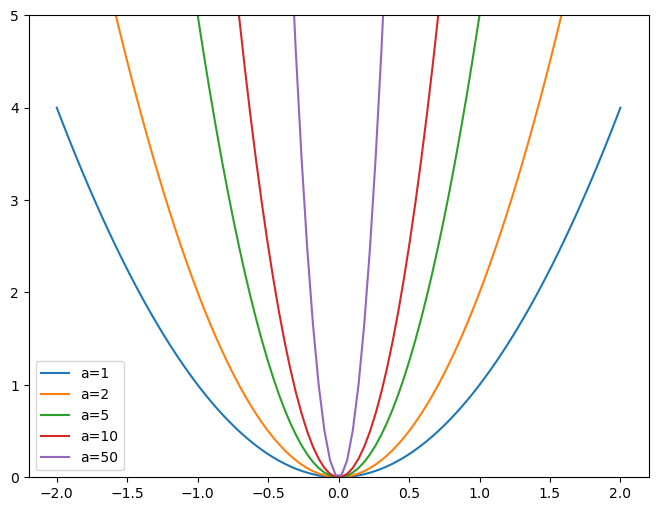

In [28]:

#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();


- the larger the weight, the more narrow the parabola, the more sharp the model is and can be overfit

**Sample implementation: unstable to add large number to loss**

```loss_with_wd = loss + wd * (parameters**2).sum()```

**instead add derivative to gradient instead**

```parameters.grad += wd * 2 * parameters```

In [31]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1) # added the weight decay parameter. Find this number by trying multiples of 10

epoch,train_loss,valid_loss,time
0,0.977690,0.936734,00:09
1,0.869874,0.856452,00:11
2,0.735558,0.820367,00:11
3,0.598101,0.809648,00:08
4,0.475997,0.811532,00:08


# Creating our own Embedding Module

In [34]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)
    
L(T().parameters())
# no parameters: - MUST WRAP IN nn.Parameter, which tells pytorch that it is a parameter.

(#0) []

In [39]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01)) # Basically identical to the pytroch Embeddings Class

In [37]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [38]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)
     

epoch,train_loss,valid_loss,time
0,0.966994,0.953808,00:07
1,0.857119,0.859410,00:09
2,0.745830,0.823646,00:09
3,0.587560,0.809008,00:10
4,0.505171,0.810043,00:09


## Interpreting Embeddings

Movies that are horrible

In [47]:
movie_bias = learn.model.movie_bias.squeeze() # squeeze for easier indexing
movie_bias
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Jury Duty (1995)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Bio-Dome (1996)',
 'Robocop 3 (1993)']

Movies that are bad

In [49]:
idxs = movie_bias.argsort(descending = True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Usual Suspects, The (1995)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)']

We can do visusalisation using PCA

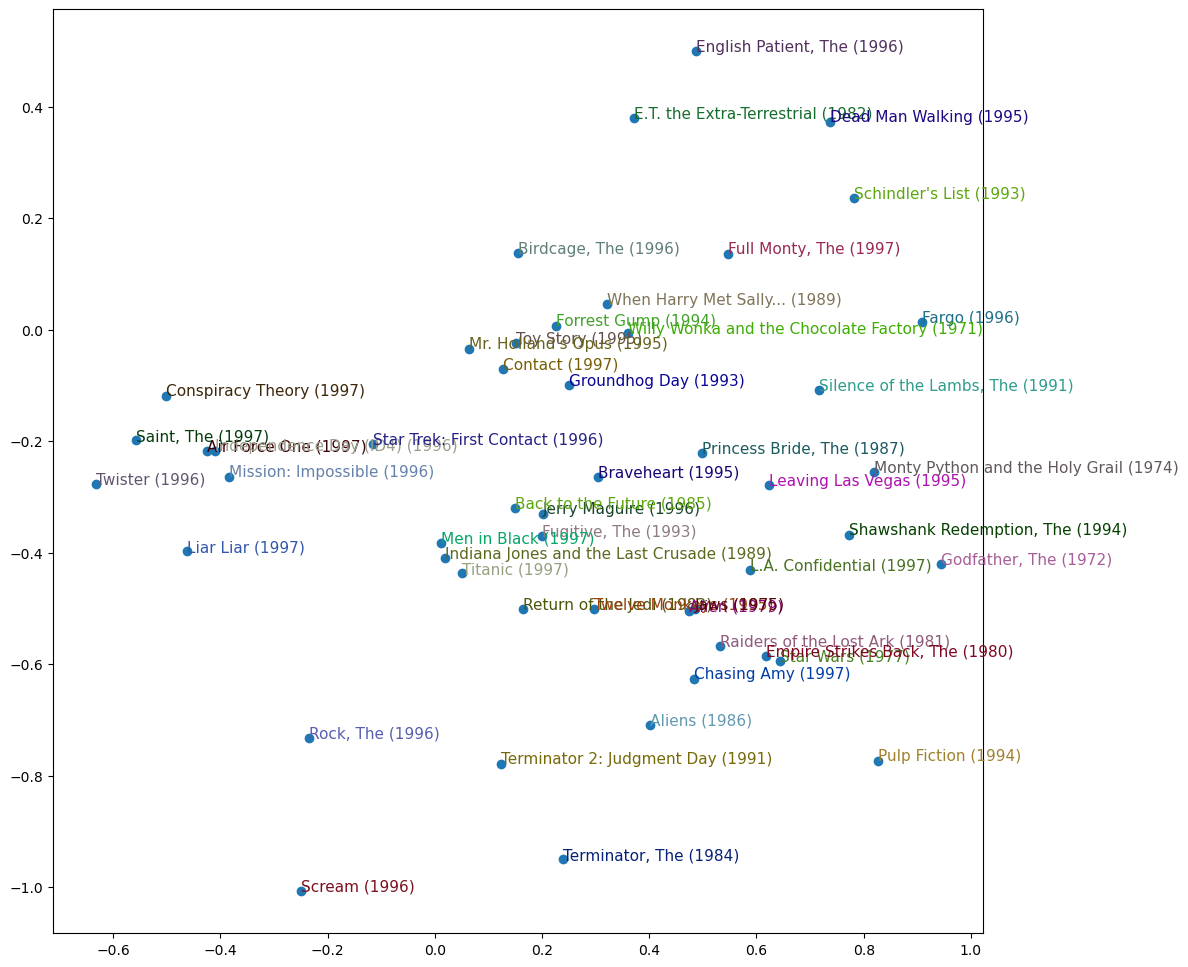

In [51]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Using fastai

In [52]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [53]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.943751,0.941707,00:13
1,0.851418,0.859993,00:13
2,0.751063,0.816664,00:13
3,0.584294,0.806483,00:13
4,0.494357,0.807271,00:11


In [54]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [55]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Usual Suspects, The (1995)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

## Embedding Distance

- calculates which movie that is closes to 'Silence of the Lambs'

In [56]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Stripes (1981)'

## Deep Learning for Collaborative Filtering

In [57]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [58]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [59]:
model = CollabNN(*embs)

In [60]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.936494,0.922198,00:14
1,0.894881,0.885625,00:15
2,0.854817,0.863007,00:19
3,0.828309,0.854013,00:14
4,0.760151,0.856221,00:12


We can easily create more hidden layers like so:

In [61]:

learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.994952,0.968677,00:13
1,0.908605,0.896492,00:14
2,0.892899,0.866502,00:14
3,0.838473,0.837155,00:12
4,0.745697,0.837423,00:17


In [62]:

@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)